In [40]:
%cd ~/code/projects/nn-play/

import keras 
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D,\
    UpSampling2D, Merge, LSTM, Flatten, ZeroPadding2D, Reshape, BatchNormalization, Dropout
from keras.layers.wrappers import TimeDistributed

from simple_container import DataContainer

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


In [41]:
IM_WIDTH = 28
IM_HEIGHT = 28
IM_CHANNELS = 1

SERIES_SHIFT = 1
EP_LEN = 100 - SERIES_SHIFT
BATCH_SIZE = 32

V_SIZE = 512

In [42]:
# predictive ae

input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
h = Convolution2D(16, 5, 5, subsample=(2,2), activation='relu', border_mode='same')(input_im)
h = Convolution2D(8, 3, 3, subsample=(2,2), activation='relu', border_mode='same')(h)
h = Flatten()(h)
v = Dense(V_SIZE, activation='relu')(h)

enc = Model(input_im, v)
enc.summary();

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 14, 14, 16)    416         input_7[0][0]                    
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 7, 7, 8)       1160        convolution2d_9[0][0]            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 392)           0           convolution2d_10[0][0]           
___________________________________________________________________________________________

In [43]:
input_v = Input(shape=(V_SIZE,))

h = Dense(8*7*7, activation='relu')(input_v)
h = Reshape((7,7,8))(h)
h = UpSampling2D((2,2))(h)
h = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(h)
h = UpSampling2D((2,2))(h)
output_im = Convolution2D(1, 5, 5, activation='sigmoid', border_mode='same')(h)

# output_im

dec = Model(input_v, output_im)
dec.summary();

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 512)           0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 392)           201096      input_8[0][0]                    
____________________________________________________________________________________________________
reshape_3 (Reshape)              (None, 7, 7, 8)       0           dense_6[0][0]                    
____________________________________________________________________________________________________
upsampling2d_5 (UpSampling2D)    (None, 14, 14, 8)     0           reshape_3[0][0]                  
___________________________________________________________________________________________

In [44]:
input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
v = enc(input_im)
output_im = dec(v)

ae = Model(input_im, output_im)
ae.summary();
ae.compile(optimizer=Adam(lr=0.0002), loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
model_7 (Model)                  (None, 512)           202792      input_9[0][0]                    
____________________________________________________________________________________________________
model_8 (Model)                  (None, 28, 28, 1)     202665      model_7[1][0]                    
Total params: 405,457
Trainable params: 405,457
Non-trainable params: 0
____________________________________________________________________________________________________


In [45]:
pred_ae = Sequential()
pred_ae.add(TimeDistributed(enc, input_shape=((EP_LEN-SERIES_SHIFT, IM_WIDTH, IM_HEIGHT, IM_CHANNELS))))
pred_ae.add(LSTM(V_SIZE, input_shape=(EP_LEN, V_SIZE), return_sequences=True))

# pred_ae.add(dec)
pred_ae.add(TimeDistributed(dec, input_shape=((EP_LEN, V_SIZE))))

# predae = Model(input_series, v_series)
pred_ae.summary();
pred_ae.compile(optimizer=Adam(lr=0.0002), loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_5 (TimeDistribut (None, 98, 512)       202792      timedistributed_input_3[0][0]    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 98, 512)       2099200     timedistributed_5[0][0]          
____________________________________________________________________________________________________
timedistributed_6 (TimeDistribut (None, 98, 28, 28, 1) 202665      lstm_3[0][0]                     
Total params: 2,504,657
Trainable params: 2,504,657
Non-trainable params: 0
____________________________________________________________________________________________________


In [46]:
images_train = DataContainer('data-balls/balls-train.pt', batch_size=32,
                          ep_len_read=EP_LEN)
images_valid = DataContainer('data-balls/balls-valid.pt', batch_size=32,
                          ep_len_read=EP_LEN)


In [ ]:
for i in tqdm.tqdm(range(1000)):
    x = images_train.get_n_random_episodes(32)
    pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

  2%|▏         | 23/1000 [00:04<03:29,  4.67it/s]

In [72]:
x = images_valid.get_n_random_episodes(32)
pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

0.0085505908

In [73]:
x = images_valid.get_n_random_episodes(32)
y = pred_ae.predict(x[:,0:-SERIES_SHIFT,...])
i = SERIES_SHIFT

In [74]:
# gif generation
import imageio
images = []
for i in range(EP_LEN-1):
    im_true = x[0,i+SERIES_SHIFT,:,:,0]
    im_gen = y[0,i,:,:,0]
    im_diff = np.abs(im_true - im_gen)
    glued = np.concatenate([im_true,
                            im_gen,
                            im_diff],
                           axis=1)
# plt.imshow(glued, cmap='gray')
    images.append(glued)
imageio.mimsave('movie.gif', images)

/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


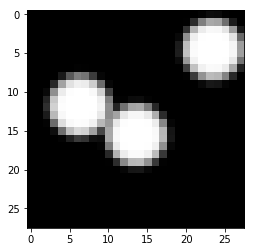

In [468]:
i += 1
plt.imshow(x[0,i,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)

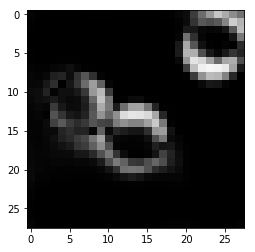

In [469]:
plt.imshow(np.abs(x[0,i,:,:,0]-y[0,i-SERIES_SHIFT,:,:,0]), cmap='gray', vmin=0.0, vmax=1.0)

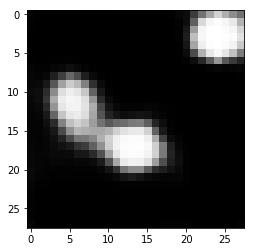

In [470]:
plt.imshow(y[0,i-SERIES_SHIFT,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)


In [347]:
x = images_train.get_batch_images().reshape((32, 28, 28, 1))
y = ae.predict(x)
i = 0

TypeError: Invalid dimensions for image data

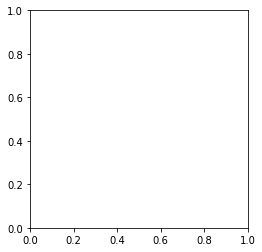

In [400]:
plt.imshow(x[i,:,:,0], cmap='gray')

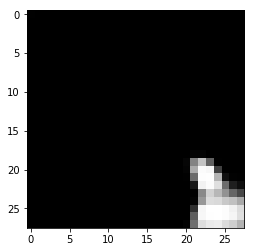

In [77]:
plt.imshow(y[i,:,:,0], cmap='gray')
i += 1